# Thư Viện

In [ ]:
!pip install pyvi
!pip install underthesea
!pip install yake
!pip install sentence-transformers

In [100]:
import pandas as pd
import numpy as np
from pprint import pprint

from matplotlib import pyplot as plt

import seaborn as sb

from pyvi import ViTokenizer, ViPosTagger
from pyvi import ViUtils
from underthesea import sentiment
from underthesea import sent_tokenize
import yake

from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Dữ Liệu

In [2]:
from google.colab import drive

drive.mount('/drive')

Mounted at /drive


In [3]:
df = pd.read_csv("/drive/My Drive/UDPTDLTM/comment_data.csv")
df.head()

,Chain,Link,Via,Datetime,Summary,Full Content,Rating,summary-processed,full_content-processed,full_content-sentiment,full_content-keywords,district
0,The Coffee House,https://www.foody.vn/ho-chi-minh/the-coffee-ho...,Android,2022-03-23 23:48:00,The Coffee House - Cà Phê Gói - 682***,Bánh mochi rẻ hơn chỗ khác. 19k 1 bánh. Nhưng ...,8.0,the coffee house cà phê gói 682,bánh mochi rẻ hơn chỗ khác. 19k 1 bánh. nhưng ...,positive,"[('chỗ khác', 0.056516451119031294), ('hơn chỗ...",Quận 5
1,The Coffee House,https://www.foody.vn/ho-chi-minh/the-coffee-ho...,Android,2022-04-08 10:21:00,"Rất ồn, không tôn trọng khách hàng",Quán đang sửa chữa rất rất ồn nhưng nhân viên ...,5.0,rất ồn không tôn trọng khách hàng,quán đang sửa chữa rất rất ồn nhưng nhân viên ...,negative,"[('quán đang', 0.0413943525254072), ('nhân viê...",Quận 7
2,The Coffee House,https://www.foody.vn/ho-chi-minh/the-coffee-ho...,iPhone,2022-05-29 08:24:00,Cappuchino đỉnh của chóp…,Bọt bẹt thua cả quán vỉa hè. Cắt cả cookie… bé...,3.4,cappuchino đỉnh của chóp,bọt bẹt thua cả quán vỉa hè. cắt cả cookie bét...,negative,"[('bọt bẹt', 0.02541909697430123), ('chất lượn...",Tp. Thủ Đức
3,Starbucks Coffee,https://www.foody.vn/ho-chi-minh/starbucks-cof...,Web,2022-07-15 15:30:00,Starbucks Coffee - Feliz En Vista,Đồ uống tạm ổn. Nhưng thái độ nhân viên khá cộ...,4.2,starbucks coffee feliz en vista,đồ uống tạm ổn. nhưng thái độ nhân viên khá cộ...,negative,"[('khách hàng', 0.07796891081290885), ('uống t...",Tp. Thủ Đức
4,Starbucks Coffee,https://www.foody.vn/ho-chi-minh/starbucks-cof...,Android,2022-01-09 15:56:00,Không phù hợp cho người làm việc,"Vị trí quán xa trung tâm, xung quanh ngoài khu...",1.6,không phù hợp cho người làm việc,vị trí quán xa trung tâm xung quanh ngoài khu ...,negative,"[('trí quán', 0.0540539347413421), ('trung tâm...",Tp. Thủ Đức


In [4]:
df['Datetime'] = df['Datetime'].astype('datetime64')

# Phân Tích

## Thống Kê

In [11]:
chains = df['Chain'].unique()

- Số lượng quán của mỗi chuỗi

In [12]:
stores_num = [len(df[df['Chain']==i]['Link'].unique()) for i in chains]

- Số lượng đánh giá positive, negative và neutral của mỗi chuỗi

In [21]:
pos = [len(df[(df['Chain']==i) & (df['full_content-sentiment']=='positive')]['Link']) for i in chains]

neg = [len(df[(df['Chain']==i) & (df['full_content-sentiment']=='negative')]['Link']) for i in chains]

neu = [len(df[(df['Chain']==i) & (df['full_content-sentiment']=='None')]['Link']) for i in chains]

- Số lượng đánh giá của mỗi chuỗi

In [16]:
reviews = [len(df[df['Chain']==i]['Link']) for i in chains]

- Bảng thống kê

In [27]:
data = {
    "stores_num": stores_num,
    "reviews_count": reviews,
    "positive_reviews": pos,
    "negative_reviews": neg,
    "neutral_reviews": neu,
}

stats = pd.DataFrame(data=data, index=chains, columns=data.keys())

stats['pos_percentage'] = (stats['positive_reviews']/stats['reviews_count']*100).round(2)
stats['neg_percentage'] = (stats['negative_reviews']/stats['reviews_count']*100).round(2)
stats['neu_percentage'] = (stats['neutral_reviews']/stats['reviews_count']*100).round(2)

stats

,stores_num,reviews_count,positive_reviews,negative_reviews,neutral_reviews,pos_percentage,neg_percentage,neu_percentage
The Coffee House,10,90,65,16,9,72.22,17.78,10.00
Starbucks Coffee,13,600,396,99,105,66.00,16.50,17.50
Highlands Coffee,43,1044,570,275,199,54.60,26.34,19.06
Phúc Long,33,951,427,378,146,44.90,39.75,15.35


- Nhận xét:
  - The Coffee House và Starbucks Coffee đều có số lượng quán được khách hàng bình luận trên Foody ít hơn so với 2 chuỗi còn lại. Tuy nhiên Starbucks lại có đến hơn 600 lượt bình luận - tương đương với trung bình mỗi quán Starbucks có 46 bình luận so với con số 9 của The Coffee House. Suy ra, trên nền tảng Foody, The Coffee House không nổi trội về mặt được khách hàng đánh giá so với 3 chuỗi cà phê kia.
  - Tiếp theo, ta thấy Highlands Coffee sỡ hữu số lượng quán có người dùng bình luận lớn nhất trong 4 chuỗi, cùng với số lượng bình luận cũng là cao nhất. Kế đến là Phúc Long. 2 thương hiệu được người dùng tích cực đưa ra đánh giá trên nền tảng Foody, và độ nhận diện thương hiệu tốt. 

## Các vấn đề

### Câu 1: Số điểm đánh giá của khách hàng như thế nào?

*Xem chi tiết trong [workbook Tableau](https://public.tableau.com/app/profile/nguyen.thai7140/viz/CoffeChainsCommentAnalysis/Cu2?publish=yes)*

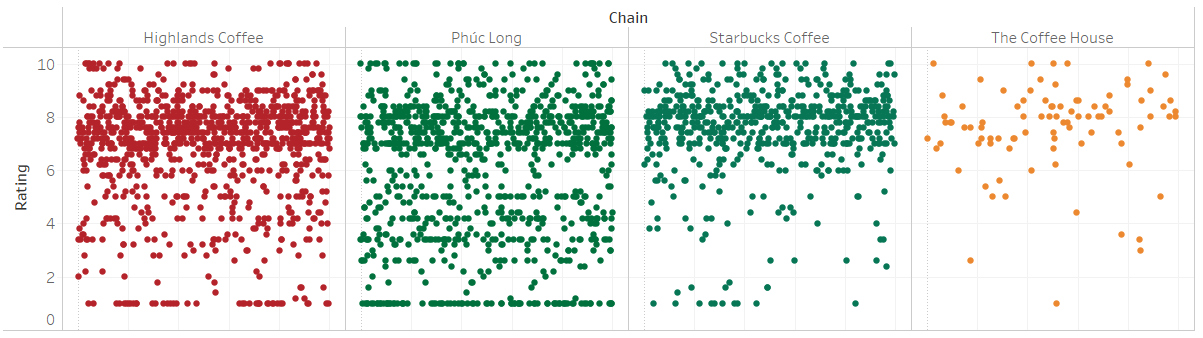

- Nhận xét:
  - Ở cả 4 chuỗi, số điểm đánh giá của khách hàng tập trung ở phân khúc 6 đến 9 điểm.
  - Tuy nhiên, ở Highlands Coffee và Phúc Long số đánh giá ở mức dưới 6 điểm vẫn tập trung nhiều hơn so với Starbucks Coffee và The Coffee House, điển hình nhất là Phúc Long. Điều này cho thấy Highlands Coffee và Phúc Long có sự đánh giá đa dạng hơn (có thể là do sự không đồng đều trong chất lượng giữa các cửa hàng trên TPHCM), trong khi đó, khách hàng của Starbucks Coffee lại khá nhất quán với nhau.

### Câu 2: Số điểm đánh giá của khách hàng phân theo đánh giá tích cực và tiêu cực.

*Xem chi tiết trong [workbook Tableau](https://public.tableau.com/app/profile/nguyen.thai7140/viz/CoffeChainsCommentAnalysis/Cu2?publish=yes)*

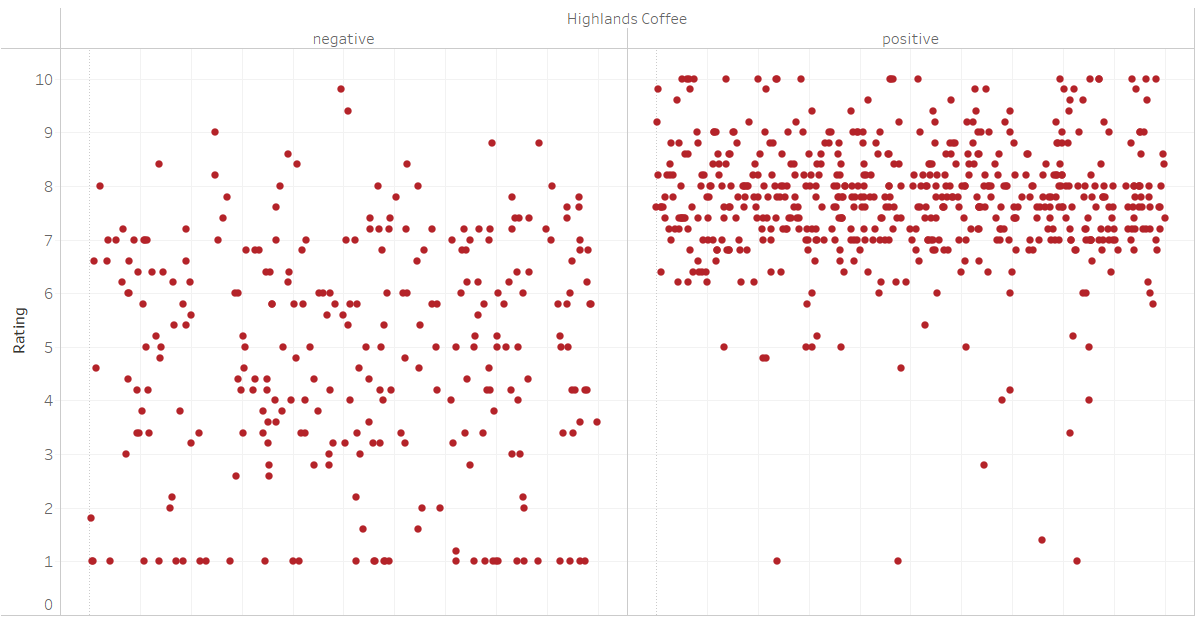

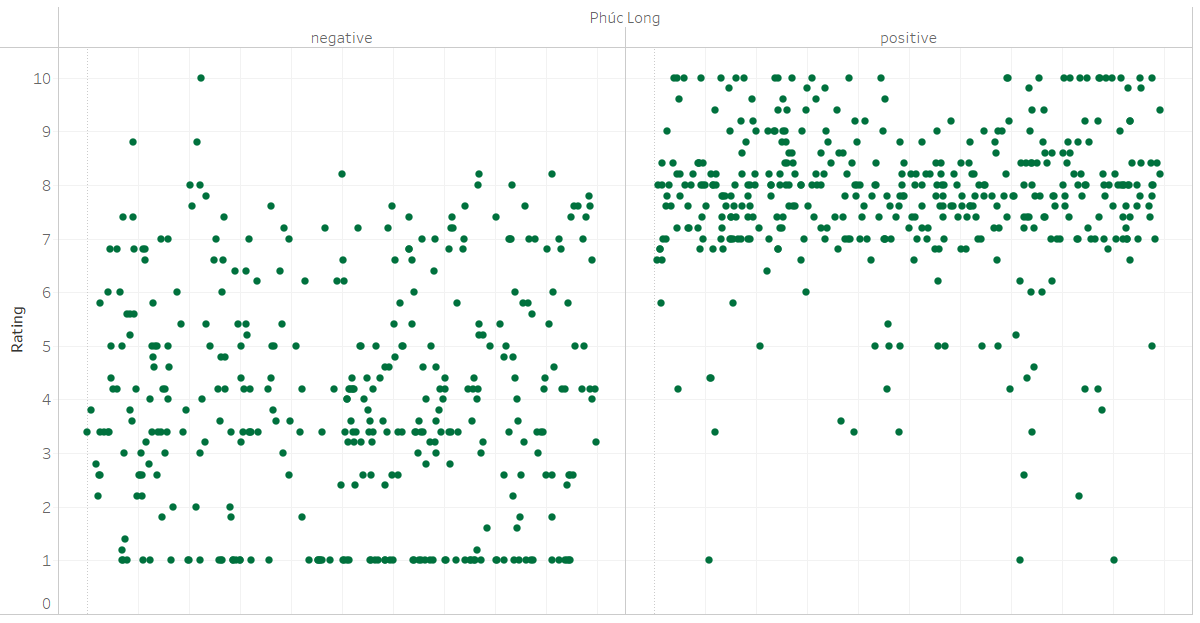

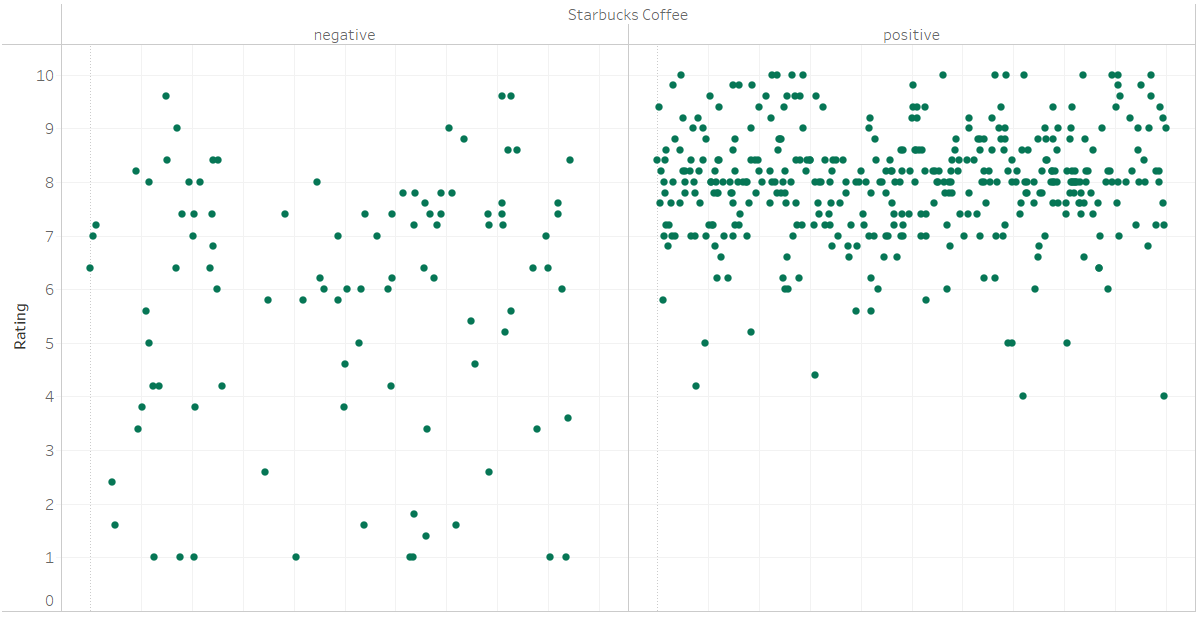

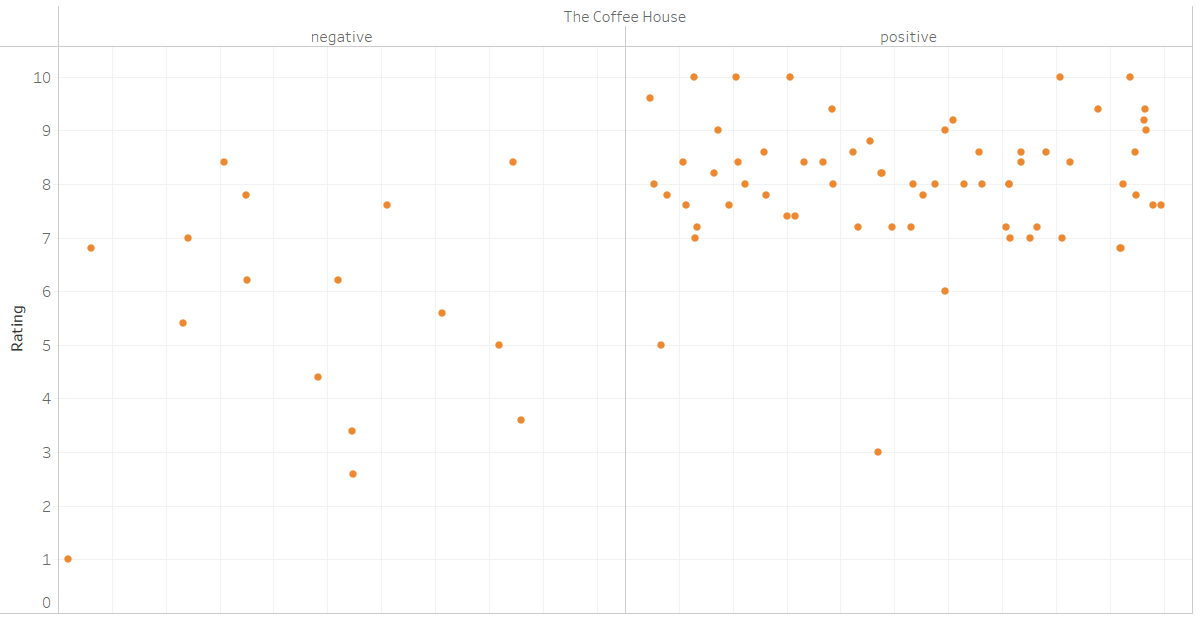

- Nhận xét:
  - Ở cả 4 chuỗi, ở những bình luận tích cực, số điểm đánh giá thường tập trung từ mức 7 điểm trở lên. Còn với những bình luận tiêu cực thường sẽ từ mức 7 điểm trở xuống.
  - Từ bảng thống kê cũng như câu 1, đến đây, ta thấy rõ hơn về sự không đồng đều trong chất lượng của Phúc Long và Highlands Coffee dẫn đến đánh giá đa dạng, không tập trung như với Starbucks

### Câu 3: Số lượng tương tác của người dùng với nhãn hàng qua thời gian.

*Xem chi tiết trong [workbook Tableau](https://public.tableau.com/app/profile/nguyen.thai7140/viz/CoffeChainsCommentAnalysis/Cu2?publish=yes)*

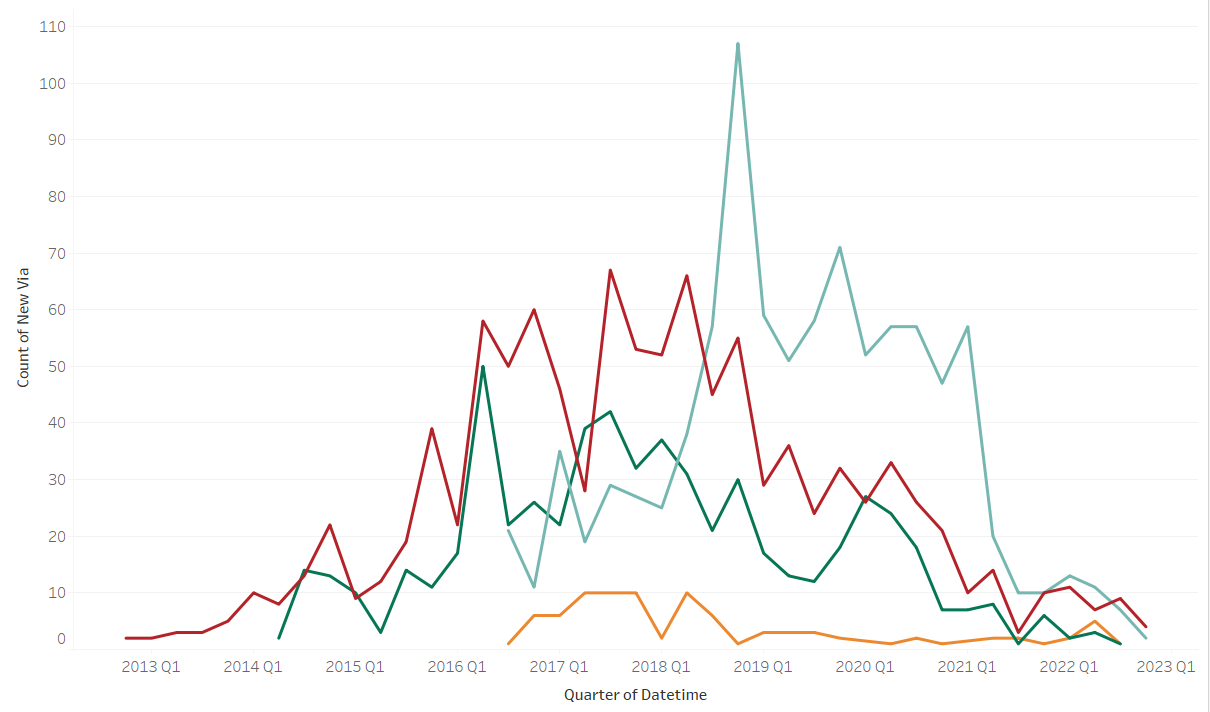

- Nhận xét:
  - Ta thấy, ở 3 chuỗi Starbucks Coffee, The Coffee House và Highlands Coffee, ở Q1 (quý 1) hằng năm đều sụt giảm số lượng bình luận trên Foody, cũng dễ hiểu vì đây là thời điểm Tết đến nên lượng khách hàng có thể sụt giảm.
  - Tuy nhiên, ở 1 vài thời điểm như Q1-2016, Q1-2018 và Q1-2020, Phúc Long lại cho thấy sự gia tăng trong lượng tương tác so với Q4 năm trước. Điều này có thể nói lên rằng những chiến lược kinh doanh của Phúc Long vào thời điểm đâu năm rất khả quan.
  - Ngoài ra, những thứ dễ dàng nhận thấy có thể kể đến như:
    - Bắt đầu từ Q1-2016 cho đến Q1-2019 cho thấy sự bùng nổ về mặt tương tác của 2 thương hiện Highlands Coffee và Phúc Long.
    - Starbucks Coffee bắt đầu được nhắc đến nhiều kể từ Q1-2018, đạt đỉnh ở Q1-2019. Sau đó, sự tương tác của khách hàng ổn định cho đến Q3-2021 (thời điểm đại dịch COVID19 bùng lên ở Việt Nam), sự sụt giảm này xảy ra ở cả 4 thương hiệu.
    - Ngoài ra, vào những lần bùng dịch đầu tiên (kể từ Q1-2019), Highlands Coffee và Phúc Long cho thấy sự sụt giảm trong khi Starbucks Coffee vẫn ổn định.

### Câu 4: Dựa theo loại cảm xúc của bình luận, những từ khóa nào mà người dùng nhắc đến ở mỗi thương hiệu?

#### Cài đặt

- Danh sách stop words

In [ ]:
!wget "https://raw.githubusercontent.com/lcminhbu/UDPTDLTM/main/Analysis/Data%20For%20Coffee%20Chains%20Analysis/stop_words.txt?token=GHSAT0AAAAAAB3T75Z75YSXV5EM6GQILLKCY4DNPNQ"

In [38]:
stopwords = open('stop_words.txt?token=GHSAT0AAAAAAB3T75Z75YSXV5EM6GQILLKCY4DNPNQ').read().splitlines()

##### Hàm

In [83]:
kw_extractor = yake.KeywordExtractor(lan='vi', n=3, stopwords=stopwords)

def get_keywords(text, n=10):

  keywords = kw_extractor.extract_keywords(text)[0:n]

  return keywords

def get_full_content(data, chain, chain_column, sentiment_column, text_column):
  pos_text = ""
  neg_text = ""

  for i in data[(data[chain_column]==chain) & (data[sentiment_column]=="positive")][text_column]:
    pos_text += str(i)

  for i in data[(data[chain_column]==chain) & (data[sentiment_column]=="negative")][text_column]:
    neg_text += str(i)
  
  return (pos_text, neg_text)

#### The Coffee House

In [70]:
cfh_text = get_full_content(df, "The Coffee House", "Chain", "full_content-sentiment", "full_content-processed")

In [84]:
# Bình luận tích cực
pprint(get_keywords(cfh_text[0].replace("the coffee house", "")))

[('nhân viên', 0.0027212904090590973),
 ('chi nhánh', 0.004845339515940541),
 ('viên', 0.006224672536260816),
 ('nhân', 0.006986528793363612),
 ('uống', 0.00699113474787144),
 ('quán', 0.007188295040019554),
 ('gian', 0.007275289375899826),
 ('trà', 0.008139411245924526),
 ('nhánh', 0.009423733096944935),
 ('ngon', 0.010141284709579555)]


- Tìm từ khóa bằng công cụ cung cấp bởi MonkeyLearn. (Xem tại [đây](https://monkeylearn.com/wordcloud/))

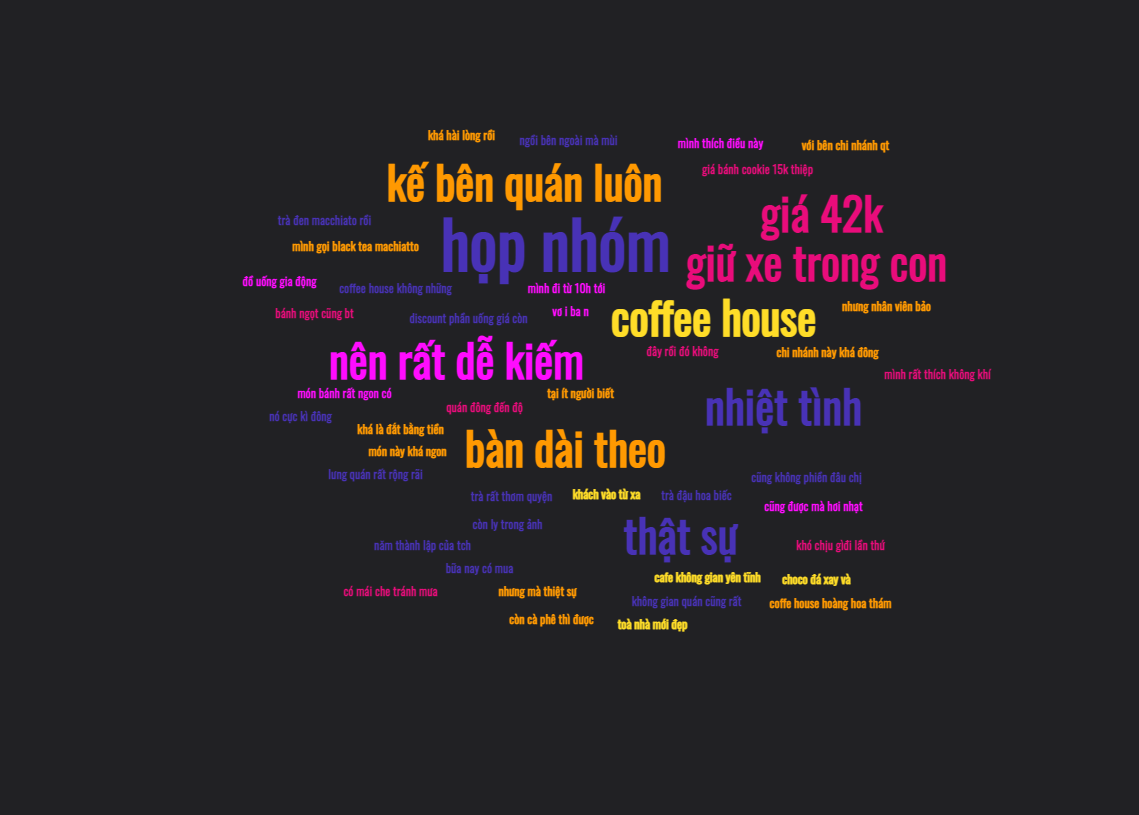

In [85]:
# Bình luận tiêu cực
pprint(get_keywords(cfh_text[1].replace("the coffee house", "")))

[('nhân viên', 0.030557427161493757),
 ('quán', 0.03141256468608249),
 ('uống', 0.03607118838433309),
 ('chỗ', 0.044723444697280644),
 ('tch', 0.051916740926418736),
 ('nhân', 0.05309549437520096),
 ('hơi', 0.053240690516198966),
 ('chi nhánh', 0.056358471135723516),
 ('viên', 0.05926325564660582),
 ('giá', 0.06248507985364443)]


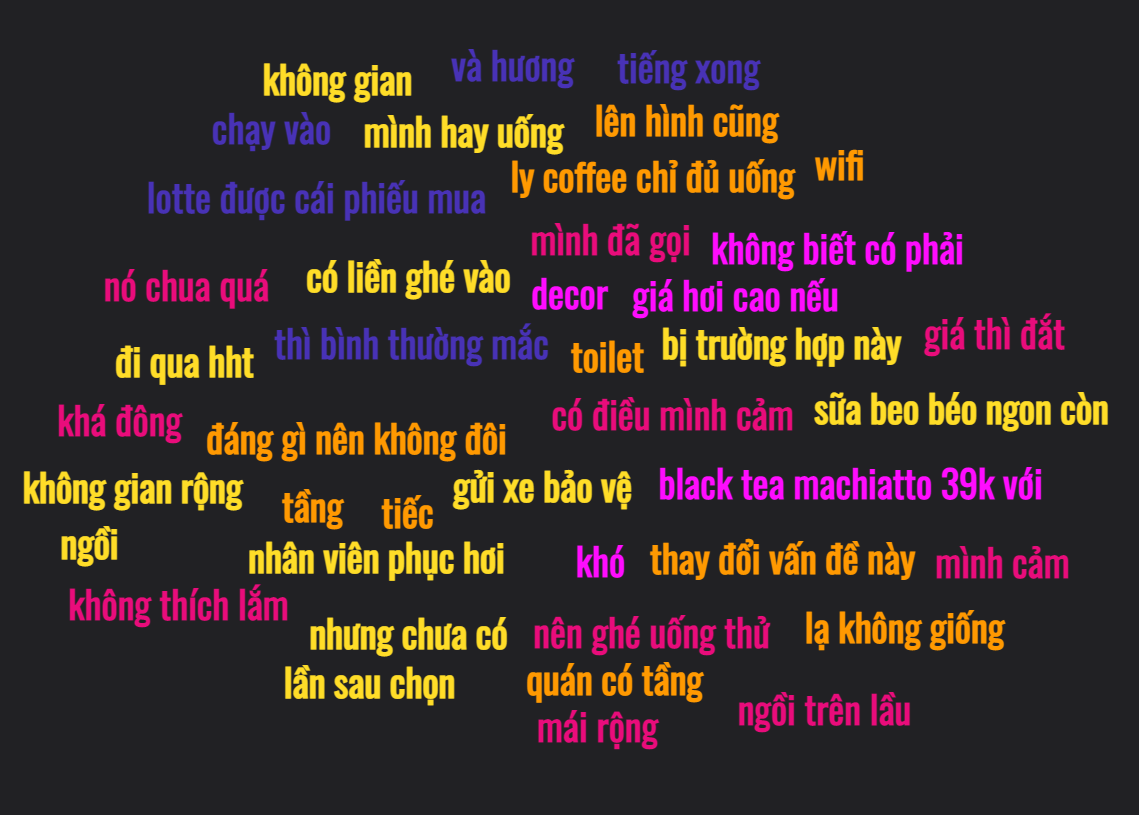

#### Highlands Coffee

In [86]:
hc_text = get_full_content(df, "Highlands Coffee", "Chain", "full_content-sentiment", "full_content-processed")

In [87]:
# Bình luận tích cực
pprint(get_keywords(hc_text[0]))

[('nhân viên', 0.00022860283712505594),
 ('uống', 0.0002853787124428144),
 ('trà', 0.00037438308802657794),
 ('ngon', 0.0004420859538593674),
 ('trà xanh', 0.0004613484677965885),
 ('freeze trà xanh', 0.0005119180663612723),
 ('trà sen vàng', 0.0007155989622550789),
 ('viên', 0.0007820916660051223),
 ('quán', 0.0007844237633332118),
 ('trà sen', 0.0008481262805015273)]


In [88]:
# Bình luận tiêu cực
pprint(get_keywords(hc_text[1]))

[('nhân viên', 0.00024209065768438344),
 ('nhân', 0.0010359594915839636),
 ('uống', 0.0010678994862588372),
 ('viên', 0.0010712330247193824),
 ('nhân viên phục', 0.0011937335430489248),
 ('trà', 0.0013621778209608841),
 ('quán', 0.001640181386734459),
 ('chi nhánh', 0.0026767913879914606),
 ('bánh', 0.00269918160839015),
 ('trà xanh', 0.0028066272198305473)]


#### Starbucks Coffee

In [89]:
sc_text = get_full_content(df, "Starbucks Coffee", "Chain", "full_content-sentiment", "full_content-processed")

In [120]:
# Bình luận tích cực
pprint(get_keywords(sc_text[0].replace("starbucks", "")))

[('nhân viên', 0.0001915320568102994),
 ('uống', 0.00038570585802938004),
 ('ngon', 0.0007374775090518693),
 ('viên', 0.0007518014151776178),
 ('nhân', 0.0008737605646490631),
 ('gian', 0.0012174759791031013),
 ('nhân viên phục', 0.0012615254327775912),
 ('món', 0.0014673090452210211),
 ('nhân viên thân', 0.0017532121429187843),
 ('chi nhánh', 0.0017919696492700078)]


In [121]:
# Bình luận tiêu cực
pprint(get_keywords(sc_text[1].replace("starbucks", "")))

[('nhân viên', 0.0016608197638319482),
 ('uống', 0.0026220964912907355),
 ('nhân', 0.0046012197229210435),
 ('viên', 0.004811829505459268),
 ('hơi', 0.007620958045114393),
 ('gian', 0.008482900510553783),
 ('ngon', 0.008637433711287794),
 ('lắm', 0.008941520804295935),
 ('giá', 0.009094416929128228),
 ('quán', 0.011127035646112404)]


#### Phúc Long

In [92]:
pl_text = get_full_content(df, "Phúc Long", "Chain", "full_content-sentiment", "full_content-processed")

In [115]:
# Bình luận tích cực
pprint(get_keywords(pl_text[0].replace("phúc long", "")))

[('trà sữa', 0.0002640842155969216),
 ('trà', 0.0002893654240100697),
 ('nhân viên', 0.0004422035593534794),
 ('uống', 0.0005170275103242852),
 ('uống trà sữa', 0.0005621132479858424),
 ('trà đào', 0.0006945259321478615),
 ('chi nhánh', 0.0008038743670554675),
 ('uống trà', 0.0008131153225765899),
 ('ngon', 0.0008986651395053501),
 ('sữa', 0.0010207220308612605)]


In [116]:
# Bình luận tiêu cực
pprint(get_keywords(pl_text[1].replace("phúc long", "")))

[('nhân viên', 0.00019989452887462825),
 ('trà sữa', 0.000351968239756168),
 ('trà', 0.00043905247399882353),
 ('chi nhánh', 0.00047968306071434437),
 ('uống', 0.0006236039970136691),
 ('viên', 0.0008717269313705481),
 ('nhân', 0.0009126254923879074),
 ('uống trà sữa', 0.001031594589400234),
 ('trà đào', 0.0012514794230586242),
 ('sữa', 0.0015022048505444184)]


#### Nhận xét chung

- Ở cả 4 thương hiệu, cả bình luận tích cực hoặc tiêu cực đều có từ khóa "nhân viên" đứng ở vị trí đầu tiên trong danh sách chứng tỏ thái độ của nhân viên ảnh hưởng sâu sắc đến trải nghiệm của khách hàng. Tiếp theo là các từ khóa liên quan tới sản phẩm của cửa hàng.
- Ở mỗi thương hiệu ta có các phát hiện như sau:
  - The Coffee House:
    - Tích cực: Thích hợp cho việc họp nhóm, gặp gỡ bạn bè, vị trí quán dễ kiếm, không gian rộng rãi, trang trí đẹp.
    -  Tiêu cực: Đông, không có chỗ ngồi ồn ào, sản phẩm.
  - Highlands Coffee: 
    - Tích cực: Nhân viên thân thiện, 2 thức uống freeze trà xanh và trà sen vàng được khách hàng khen nhiều.
  - Starbucks Coffee:
    - Tiêu cực: Giá của sản phẩm.
  - Phúc Long:
    - Tích cực: Sản phẩm trà sữa và trà đào của Phúc Long khá được yêu thích.
    - Tiêu cực: Từ các bình luận tiêu cực, các từ khóa được rút trích ra lại nói về trà sữa và trà đào của Phúc Long. Cho thấy chất lượng của các sản phẩm này không đồng đều giữa các cửa hàng và cả thời gian.